# A2.2 Árboles de decisión

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix
import statsmodels.api as sm

#### 1. Importación de los datos al ambiente de trabajo. Igualmente que en A2.1 y P1, se aplican el mismo proceso de filtración, separación en dos columnas para fecha y hora, así como la selección de características, y la aplicación del método Tukey para permanecer con los datos que son estadísticamente relevantes.

In [ ]:
data = pd.read_excel("SOLICITUD_289-24_septiembre.xlsx")

In [10]:
data_filled = data.apply(lambda x: x.fillna(x.mean()), axis=0)
nan_percentage = data_filled.isna().mean() * 100
data_filled['Fecha y hora'] = pd.to_datetime(data_filled['Fecha y hora'], format='%m/%d/%Y %I:%M:%S %p')
data_filled['Fecha'] = data_filled['Fecha y hora'].dt.date
data_filled['Hora'] = data_filled['Fecha y hora'].dt.time
reference_date = pd.to_datetime('2021-01-01')
data_filled['Fecha'] = (pd.to_datetime(data_filled['Fecha']) - reference_date).dt.days
# Convertir la columna 'Hora' en una variable cuantitativa (número de minutos desde la medianoche)
data_filled['Hora'] = data_filled['Fecha y hora'].dt.hour * 60 + data_filled['Fecha y hora'].dt.minute
# Eliminar la columna original 'Fecha y hora'
data_filled = data_filled.drop(columns=['Fecha y hora'])

# Eliminación de variables con alta colinealidad
data_filled = data_filled.drop(columns=['NO (ppb)', 'NOx (ppb) '])

# Método Tukey
def tukey_outliers(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_b = Q1 - 1.5 * IQR
    upper_b = Q3 + 1.5 * IQR
    return lower_b, upper_b

for column in data_filled.columns:
    if data_filled[column].dtype in ['int64', 'float64']:
        lower_b, upper_b = tukey_outliers(data_filled[column])
        
        # Identify outliers
        outliers = data_filled[(data_filled[column] < lower_b) | (data_filled[column] > upper_b)]

data_filled = data_filled[data_filled['CO (ppm)'] <= 30]

features = ['CO (ppm)', 'NO2 (ppb)', 'O3 (ppb)', 'PM10 (µg/m3)', 'PRS (mmHg)', 
            'RAINF (mm/h)', 'RH (%)', 'SO2 (ppb)', 'SR (kWh/m2)', 'Temp (°C)', 
            'WSR (km/h)', 'WDR (°)', 'Fecha', 'Hora']

#### 

In [16]:
min_samples = 2  # Adjust this based on dataset size
valid_classes = y.value_counts()[y.value_counts() >= min_samples].index
data_filtered = data_filled[data_filled['PM2,5 (µg/m3)'].isin(valid_classes)]

X = data_filtered[features]
y = data_filtered['PM2,5 (µg/m3)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

print("Training set class distribution:")
print(y_train.value_counts(normalize=True))
print("Test set class distribution:")
print(y_test.value_counts(normalize=True))

Training set class distribution:
17.485966    0.152099
8.000000     0.004230
15.000000    0.004230
14.000000    0.004092
6.000000     0.003908
               ...   
35.810000    0.000046
29.840000    0.000046
28.200000    0.000046
35.580000    0.000046
61.850000    0.000046
Name: PM2,5 (µg/m3), Length: 3300, dtype: float64
Test set class distribution:
17.485966    0.152130
15.000000    0.004291
8.000000     0.004184
14.000000    0.004077
16.000000    0.003862
               ...   
25.920000    0.000107
36.970000    0.000107
12.740000    0.000107
28.560000    0.000107
31.780000    0.000107
Name: PM2,5 (µg/m3), Length: 3300, dtype: float64


#### 2. Se hace una regresión logística con la función Generalized Linear Model (GLM), se consideran todas las variables seleccionadas por el método de selección como predictores. Se imprimirán los resultados como un resumen estadístico, para después seleccionar las dos variables más significativas usando los valores p más pequeños.

In [18]:
X_train_const = sm.add_constant(X_train)  # Adding constant term for statsmodels
glm_model = sm.GLM(y_train, X_train_const, family=sm.families.Binomial()).fit()
print(glm_model.summary())

# Selecting the two most relevant variables (excluding 'const')
top_vars = [var for var in glm_model.pvalues.nsmallest(3).index.tolist() if var != 'const']
X_train_reduced = X_train[top_vars]
X_test_reduced = X_test[top_vars]

                 Generalized Linear Model Regression Results                  
Dep. Variable:          PM2,5 (µg/m3)   No. Observations:                21749
Model:                            GLM   Df Residuals:                    21734
Model Family:                Binomial   Df Model:                           14
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                   -inf
Date:                Mon, 31 Mar 2025   Deviance:                   2.6237e+07
Time:                        19:16:52   Pearson chi2:                 2.95e+22
No. Iterations:                     2   Pseudo R-squ. (CS):                nan
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         9.795e+17   1.05e+08   9.32e+09   

c:\Users\J_Hum\miniconda3\Lib\site-packages\statsmodels\genmod\families\family.py:1056: RuntimeWarning: invalid value encountered in log
  special.gammaln(n - y + 1) + y * np.log(mu / (1 - mu + 1e-20)) +
c:\Users\J_Hum\miniconda3\Lib\site-packages\statsmodels\genmod\families\family.py:1057: RuntimeWarning: invalid value encountered in log
  n * np.log(1 - mu + 1e-20)) * var_weights


#### 3. Se crea un modelo LDA, usando los datos filtrados de los pasos anteriores. Se grafica la función del discriminante para visualizar la distinción entre clases, las cuales se diferencian a través de sus colores.

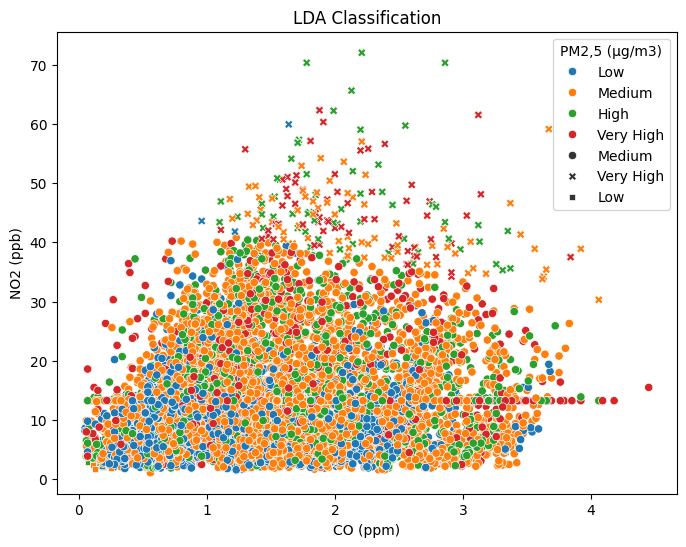

In [20]:
# Discretize the target variable into bins
bins = [y_train.min() - 1, 10, 20, 30, y_train.max() + 1]  # Define bins
labels = ['Low', 'Medium', 'High', 'Very High']  # Define labels for bins
y_train_binned = pd.cut(y_train, bins=bins, labels=labels)
y_test_binned = pd.cut(y_test, bins=bins, labels=labels)

lda = LinearDiscriminantAnalysis()
lda.fit(X_train_reduced, y_train_binned)
y_pred_lda = lda.predict(X_test_reduced)

# Visualization
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_test_reduced[top_vars[0]], y=X_test_reduced[top_vars[1]], hue=y_test_binned, style=y_pred_lda)
plt.xlabel(top_vars[0])
plt.ylabel(top_vars[1])
plt.title("LDA Classification")
plt.show()

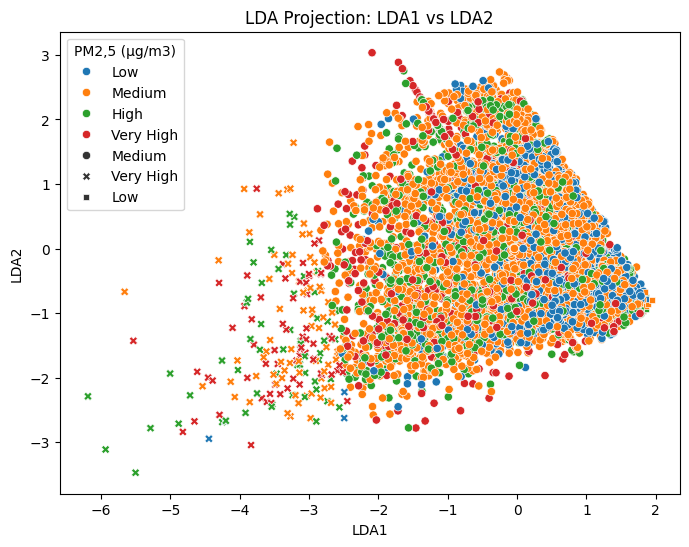

In [25]:
# Transform data into LDA space
X_train_lda = lda.transform(X_train_reduced)
X_test_lda = lda.transform(X_test_reduced)

# Create a scatter plot of LDA1 vs LDA2
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_test_lda[:, 0], y=X_test_lda[:, 1], hue=y_test_binned, style=y_pred_lda)
plt.xlabel("LDA1")
plt.ylabel("LDA2")
plt.title("LDA Projection: LDA1 vs LDA2")
plt.show()

#### 4. Se crea un árbol de decisión, y se aplica validación cruzada Leave-One-Out (LOOCV) para encontrar el mejor parámetro de regularización &alpha; y con ello aplicar PODA y reducir el Gini index.

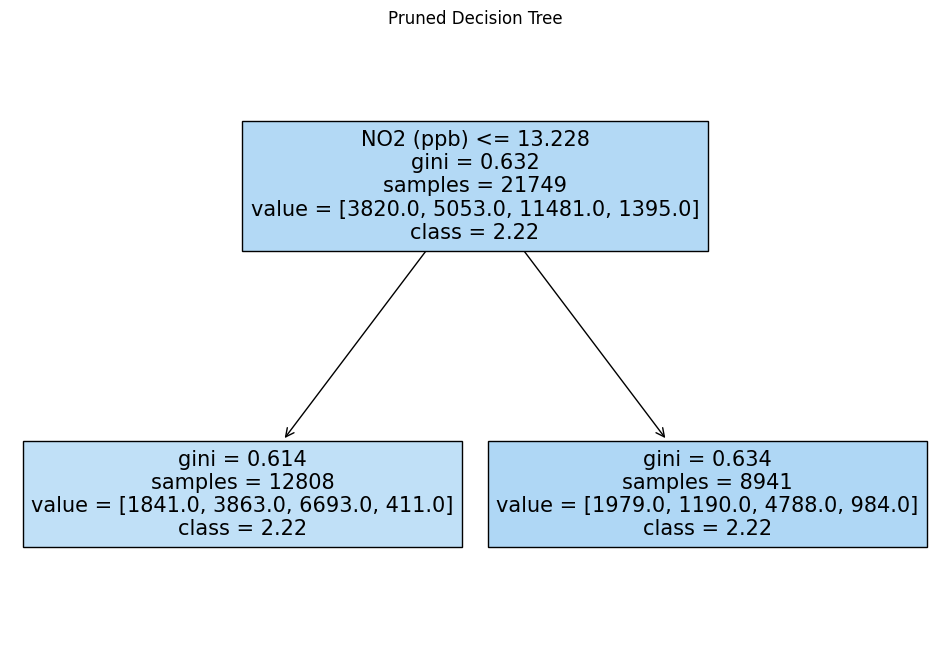

In [22]:
from sklearn.model_selection import cross_val_score

alphas = np.linspace(0.001, 0.05, 50)
best_alpha = min(alphas, key=lambda alpha: np.mean(cross_val_score(DecisionTreeClassifier(ccp_alpha=alpha), X_train_reduced, y_train_binned, cv=5)))

tree = DecisionTreeClassifier(ccp_alpha=best_alpha)
tree.fit(X_train_reduced, y_train_binned)
y_pred_tree = tree.predict(X_test_reduced)

plt.figure(figsize=(12, 8))
plot_tree(tree, filled=True, feature_names=top_vars, class_names=np.unique(y).astype(str))
plt.title("Pruned Decision Tree")
plt.show()

#### 5. Finalmente, se imprimen las métricas como la matriz de confusión y un reporte de clasificación con el objetivo de comparar los modelos LDA y el árbol de decisión.

In [24]:
print("LDA Classification Report:")
print(classification_report(y_test_binned, y_pred_lda))
print("Decision Tree Classification Report:")
print(classification_report(y_test_binned, y_pred_tree))

print("Confusion Matrix for LDA:")
print(confusion_matrix(y_test_binned, y_pred_lda))
print("Confusion Matrix for Decision Tree:")
print(confusion_matrix(y_test_binned, y_pred_tree))

LDA Classification Report:
              precision    recall  f1-score   support

        High       0.00      0.00      0.00      1577
         Low       0.42      0.00      0.00      2148
      Medium       0.52      0.98      0.68      4819
   Very High       0.33      0.08      0.13       777

    accuracy                           0.52      9321
   macro avg       0.32      0.27      0.21      9321
weighted avg       0.39      0.52      0.36      9321

Decision Tree Classification Report:


c:\Users\J_Hum\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\J_Hum\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\J_Hum\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\J_Hum\miniconda3\Lib\site-pa

              precision    recall  f1-score   support

        High       0.00      0.00      0.00      1577
         Low       0.00      0.00      0.00      2148
      Medium       0.52      1.00      0.68      4819
   Very High       0.00      0.00      0.00       777

    accuracy                           0.52      9321
   macro avg       0.13      0.25      0.17      9321
weighted avg       0.27      0.52      0.35      9321

Confusion Matrix for LDA:
[[   0    2 1519   56]
 [   0    5 2139    4]
 [   0    4 4740   75]
 [   0    1  710   66]]
Confusion Matrix for Decision Tree:
[[   0    0 1577    0]
 [   0    0 2148    0]
 [   0    0 4819    0]
 [   0    0  777    0]]


c:\Users\J_Hum\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### Con base a los resultados mostrados en pantalla, se puede determinar que 